## **Import thư viện cần thiết**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from PIL import Image
import copy
import time

import os
os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report

import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


## **Data Augmentation using Albumentations**

In [3]:
data_transforms = {
    'train': A.Compose([
        A.Resize(224, 224),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(),
        A.Rotate(limit = 15),
        A.CoarseDropout(max_holes = 1, max_height = 16, max_width = 16, fill_value = 0, mask_fill_value=None),
        A.Normalize(mean= (0.485, 0.456, 0.406), std= (0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
}

## **Custom Dataset Loader**

In [4]:
class CustomImageDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageDataset, self).__init__(root, transform=None)
        self.custom_transform = transform

    def __getitem__(self, index):
        image, label = super(CustomImageDataset, self).__getitem__(index)
        image = np.array(image)
        if self.custom_transform:
            augmented = self.custom_transform(image = image)
            image = augmented['image']
        return image, label

## **Dataset Loading and Splitting**

In [5]:
data_dir = '/kaggle/input/brain-tumor-mri-scans'
full_dataset = CustomImageDataset(data_dir, transform=data_transforms['train'])

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.custom_transform = data_transforms['val']
test_dataset.dataset.custom_transform = data_transforms['val']

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


## **Model Architecture**

In [6]:
# Mô hình ResNet50
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 4)
# model = model.to(device)


class CustomCNN(nn.Module):
    def __init__(self, num_classes = 4):
        super(CustomCNN, self).__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers 
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Dropout to reduce overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        #Convolution + ReLU + Pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the feature map
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model = CustomCNN(num_classes=4).to(device)

## **Loss function and Optimizer**

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

## **Training and Evaluation Functions**

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_eposhs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss':[], 'val_loss':[], 'val_acc':[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_loss)
        print(f"Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Acc: {val_acc}")
        history['train_loss'].append(running_loss/len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history


In [9]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(data_loader), 100 * correct / total

## **Training the model**

In [10]:
num_epochs = 25
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/25
Train Loss: 0.7987141618867973, Val Loss: 0.43857301274935406, Val Acc: 83.47578347578347
Epoch 2/25
Train Loss: 0.384302482008934, Val Loss: 0.3202981515364213, Val Acc: 88.03418803418803
Epoch 3/25
Train Loss: 0.24541386653511943, Val Loss: 0.22241552286978925, Val Acc: 92.49762583095917
Epoch 4/25
Train Loss: 0.167238075688312, Val Loss: 0.18049217385211677, Val Acc: 94.11206077872744
Epoch 5/25
Train Loss: 0.11163430983599808, Val Loss: 0.19013670312635828, Val Acc: 93.44729344729345
Epoch 6/25
Train Loss: 0.08094768978159439, Val Loss: 0.18969469707967204, Val Acc: 94.20702754036087
Epoch 7/25
Train Loss: 0.0634402218021531, Val Loss: 0.1265538314385622, Val Acc: 96.58119658119658
Epoch 8/25
Train Loss: 0.04977840114068905, Val Loss: 0.17891353504224258, Val Acc: 95.44159544159544
Epoch 9/25
Train Loss: 0.03940229035765401, Val Loss: 0.13311431729093645, Val Acc: 96.01139601139602
Epoch 10/25
Train Loss: 0.033757337196102646, Val Loss: 0.2586437703928713, Val Acc: 93.92

## **Evaluating the Model on the Test Set**

In [11]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}%")

Test Loss: 0.2562856428946058, Test Accuracy: 95.9203036053131%


## **Training and Validation Metrics for Model Comparison**

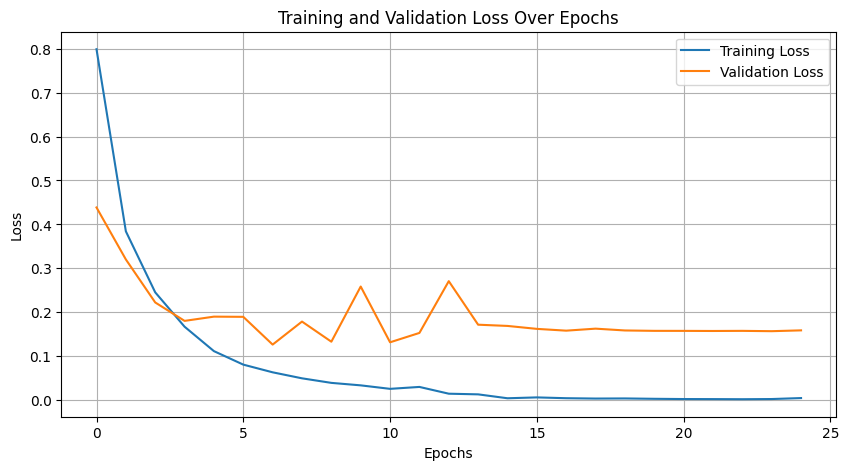

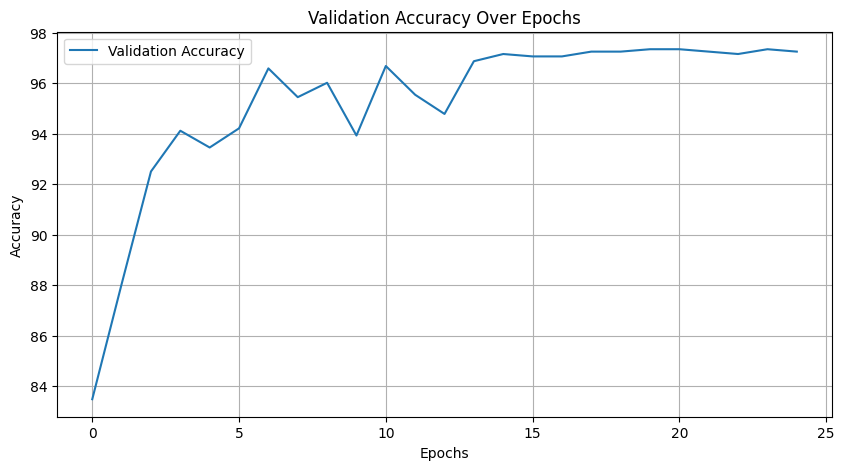

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
#=============================================================
plt.figure(figsize=(10, 5))
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## **Confusion Matrix and Classification Report**

In [13]:
def plot_confusion_matrix(model, data_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels

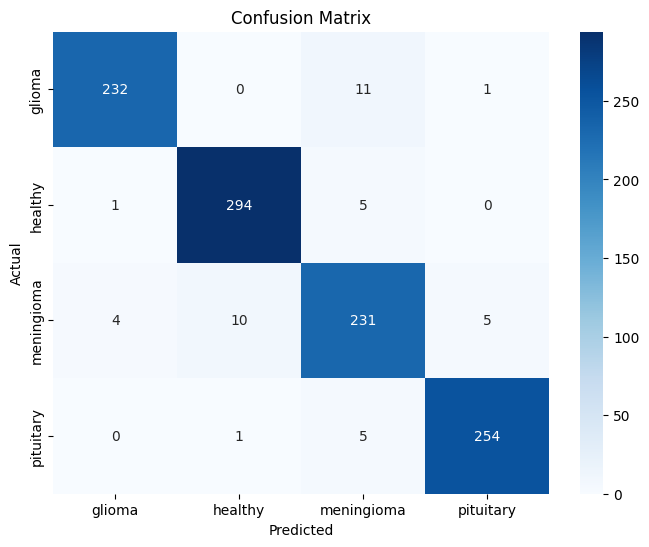

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.95      0.96       244
     healthy       0.96      0.98      0.97       300
  meningioma       0.92      0.92      0.92       250
   pituitary       0.98      0.98      0.98       260

    accuracy                           0.96      1054
   macro avg       0.96      0.96      0.96      1054
weighted avg       0.96      0.96      0.96      1054



In [14]:
classes = ['glioma', 'healthy', 'meningioma', 'pituitary']
all_preds, all_labels = plot_confusion_matrix(model, test_loader, classes)
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

## **Saving The Model**

In [15]:
model_path = '/kaggle/working/brain_tumor_model2.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved at {model_path}')

Model saved at /kaggle/working/brain_tumor_model2.pth
